In [1]:
import psycopg2
import sys
import numpy as np
import pandas as pd
from nltk import pos_tag
from nltk import pos_tag_sents
from nltk.tokenize import TweetTokenizer
from textblob import TextBlob
from __future__ import division
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [299]:
from treeinterpreter import treeinterpreter as ti

In [144]:
from nltk.corpus import stopwords
stopset = set(stopwords.words('english'))
def stopword_filtered_word_feats(words):
    return [word for word in words if word not in stopset]

def extract_hash_tags(s):
    return set(part[1:] for part in s.split() if part.startswith('#'))

def extract_http(s):
    return set(part for part in s.split() if part.startswith('http'))

In [264]:
tknzr = TweetTokenizer(strip_handles=True)
analyzer = SentimentIntensityAnalyzer()

def get_features(tweet_str):
    twt_tkns = tknzr.tokenize(tweet_str)
    senti = analyzer.polarity_scores(' '.join(stopword_filtered_word_feats(twt_tkns)))

    VB_count = 0
    PRP_count = 0
    JJ_count = 0
    for word, tag in pos_tag(twt_tkns):
        if tag == 'VB':
            VB_count += 1
        if tag == 'PRP':
            PRP_count += 1
        if tag == 'JJ':
            JJ_count += 1
    return (senti['pos'], senti['neg'], senti['neu'], senti['compound'],
            len(twt_tkns), len(extract_hash_tags(tweet_str)), len(extract_http(tweet_str)),
            VB_count, PRP_count, JJ_count)
            


In [265]:
con = psycopg2.connect("dbname='tweetdat' user='andric'")
sql_query = """
            SELECT rt_tweet, rt_count/user_followers_count::float as rt_influence \
            FROM la_tweets \
            WHERE rt_status = 1 AND user_followers_count > 0 \
            ORDER BY rt_influence DESC LIMIT 195000;
            """
query_results = pd.read_sql_query(sql_query, con)
if con:
    con.close()

In [266]:
rts_nodups = query_results['rt_tweet'].drop_duplicates()
popular_tweets = rts_nodups.apply(get_features).apply(pd.Series)
print popular_tweets.shape

(19616, 10)


In [319]:
list(rts_nodups[:10])

["1,000,000 retweets and I'll make a Harambe movie \xf0\x9f\x99\x88\xf0\x9f\x99\x8a",
 '@realDonaldTrump #Merylsayshi',
 'Hey @realDonaldTrump u up?',
 'My thoughts and prayers go out to everyone affected in Manchester.',
 'She paints over Pokemon cards \xf0\x9f\x91\x8f\xf0\x9f\x91\x8f\xf0\x9f\x91\x8f https://t.co/KeRuAFMc9U',
 "My @ChipotleTweets submission:\n\nFill my mouth with meat\nChipotle's a tasty treat\nMakes me twist my teats",
 'Ask me if I give a motherfuck ?!!',
 'Everybody. 5/5/17 https://t.co/TkvXk6Iqvq',
 "You guys wanted it, so I'm giving away 7 iPhone 7's! Click here to find out how to win it! https://t.co/vQfvtnEHqu\xe2\x80\xa6 https://t.co/weeOdI1Tjg",
 "As a matter of principle, I've resigned from the President's Council over the  #ParisAgreement withdrawal."]

In [324]:
rts_nodups[20:35]

28    me at the function, realizing i never want to ...
30    Can't make it to the #BBMAs tonight and know I...
32    All my feelings on fire... #BadLiar is out now...
34                              https://t.co/AC6kz2hH9E
35    If President fired Bob Mueller, Congress would...
36    gps: you'll arrive in 1hr...\nme: bet. https:/...
39                                    Cory &lt;3's you.
40    imagine boycotting beauty &amp; the beast beca...
41           now THATS a sunset https://t.co/3cBOQ6czvd
42          19.06\n#zaynxversus https://t.co/C2CxekYgYk
44                   #SGBadLiar https://t.co/7UNcqpse9i
46    This is my Mums best friend \nPlease help in a...
47    Took a couple months off giveaways so I could ...
49    2 days til @13ReasonsWhy… Here's a 1st listen ...
50    There are more important things to talk about....
Name: rt_tweet, dtype: object

In [251]:
from sklearn.feature_extraction.text import TfidfVectorizer

sklearn_tfidf = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=tknzr.tokenize)
sklearn_representation = sklearn_tfidf.fit_transform(list(rts_nodups[:10]))


In [256]:
import math
def cosine_similarity(vector1, vector2):
    dot_product = sum(p*q for p,q in zip(vector1, vector2))
    magnitude = math.sqrt(sum([val**2 for val in vector1])) * math.sqrt(sum([val**2 for val in vector2]))
    if not magnitude:
        return 0
    return dot_product/magnitude

In [257]:
skl_tfidf_comparisons = []
for count_0, doc_0 in enumerate(sklearn_representation.toarray()):
    for count_1, doc_1 in enumerate(sklearn_representation.toarray()):
        skl_tfidf_comparisons.append((cosine_similarity(doc_0, doc_1), count_0, count_1))

In [267]:
con = psycopg2.connect("dbname='tweetdat' user='andric'")
sql_query = """
            SELECT tweet \
            FROM la_tweets \
            WHERE rt_status = 0 AND user_followers_count > 0
            LIMIT 50000;
            """
query_results = pd.read_sql_query(sql_query, con)
if con:
    con.close()

In [268]:
others_nodups = query_results['tweet'].drop_duplicates()
nonpopular_tweets = others_nodups.apply(get_features).apply(pd.Series)

In [269]:
num_tweets = popular_tweets.shape[0]
nonpopular_tweets = nonpopular_tweets.sample(n=num_tweets)

In [270]:
print popular_tweets.mean()
print nonpopular_tweets.mean()

0     0.159230
1     0.081395
2     0.758716
3     0.118574
4    15.318770
5     0.337938
6     0.731444
7     0.567598
8     0.662571
9     1.001122
dtype: float64
0     0.139730
1     0.070497
2     0.786003
3     0.091757
4    11.839315
5     0.320810
6     0.608840
7     0.409054
8     0.483381
9     0.740110
dtype: float64


In [279]:
num_examples = num_tweets
y = np.hstack((np.array(num_examples*[1]), np.array(num_examples*[0])))
X = np.vstack((popular_tweets.as_matrix()[:num_examples, :], nonpopular_tweets.as_matrix()[:num_examples, :]))

In [297]:
from sklearn.metrics import classification_report

In [303]:
ss = StandardScaler()
ssX = ss.fit_transform(X)

indices = [0,1,2,3,4]
X_train, X_test, y_train, y_test = train_test_split(ssX, y,
                                                    test_size=0.33)

feat_labels = ['pos', 'neg', 'neutral', 'valence', 'numbertokens', 'numberhashtags', 'numberlinks',
               'verbs', 'persprp', 'adjectives']
#feat_labels = [feat_labels[i] for i in indices]

forest = RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='entropy', random_state=1)
#forest = RandomForestClassifier()
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred)
forest_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (forest_train, forest_test))
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print('AUC: %f' % roc_auc)
print(classification_report(y_test, y_test_pred))

  1) numbertokens                   0.246239
  2) valence                        0.155781
  3) neutral                        0.149083
  4) pos                            0.116812
  5) neg                            0.074230
  6) adjectives                     0.069110
  7) verbs                          0.052933
  8) persprp                        0.051170
  9) numberhashtags                 0.046152
 10) numberlinks                    0.038491
Train/test accuracies: 0.879/0.608
AUC: 0.607717
             precision    recall  f1-score   support

          0       0.61      0.58      0.59      6428
          1       0.60      0.64      0.62      6519

avg / total       0.61      0.61      0.61     12947



In [310]:
print forest.predict(X_test[0, :].reshape(1, -1))
print forest.predict_proba(X_test[0, :].reshape(1, -1))
prediction, bias, contributions = ti.predict(forest, X_test[0, :].reshape(1, -1))
print(prediction, bias, contributions)

[1]
[[ 0.44490518  0.55509482]]
(array([[ 0.44490518,  0.55509482]]), array([[ 0.50121971,  0.49878029]]), array([[[ 0.00592494, -0.00592494],
        [ 0.00143833, -0.00143833],
        [ 0.02666579, -0.02666579],
        [ 0.00671949, -0.00671949],
        [-0.06447407,  0.06447407],
        [-0.00909314,  0.00909314],
        [-0.04908437,  0.04908437],
        [-0.00444101,  0.00444101],
        [ 0.01881483, -0.01881483],
        [ 0.01121469, -0.01121469]]]))


In [318]:
contributions

array([[[ 0.00592494, -0.00592494],
        [ 0.00143833, -0.00143833],
        [ 0.02666579, -0.02666579],
        [ 0.00671949, -0.00671949],
        [-0.06447407,  0.06447407],
        [-0.00909314,  0.00909314],
        [-0.04908437,  0.04908437],
        [-0.00444101,  0.00444101],
        [ 0.01881483, -0.01881483],
        [ 0.01121469, -0.01121469]]])

In [192]:
print forest.predict_proba(np.array(get_features("Yeah! So happy!! Today is a great day for all of us!")).reshape(1, -1))
print forest.predict(np.array(get_features("Yeah! So happy!! Today is a great day for all of us!")).reshape(1, -1))
print forest.predict_proba(np.array(get_features("meh")).reshape(1, -1))
print forest.predict(np.array(get_features("meh")).reshape(1, -1))
print forest.predict(X_test[0, :].reshape(1, -1))
#print X_test[0, :].reshape(1, -1)

[[ 0.36  0.64]]
[1]
[[ 0.52  0.48]]
[0]
[0]


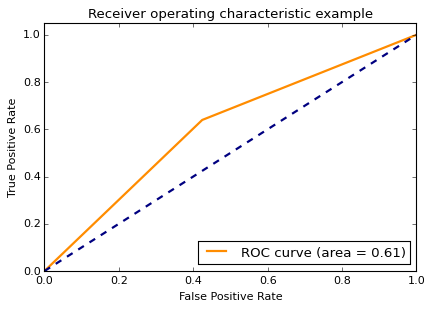

In [304]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [99]:
np.array(get_features("Yeah! So happy. Today is a great day for all of us!")).reshape(1, -1)

array([[  0.736,   0.   ,   0.264,   0.903,  15.   ,   0.   ,   0.   ,
          0.   ,   1.   ,   2.   ]])

In [ ]:
ss = StandardScaler()
ssX = ss.fit_transform(X)

indices = [0,1,2,3,4]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33)

feat_labels = ['pos', 'neg', 'neutral', 'valence', 'numbertokens', 'numberhashtags', 'numberlinks',
               'verbs', 'persprp', 'adjectives']
#feat_labels = [feat_labels[i] for i in indices]

forest = RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='entropy', random_state=1)
#forest = RandomForestClassifier()
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred)
forest_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (forest_train, forest_test))
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print('AUC: %f' % roc_auc)

In [142]:
from collections import OrderedDict

/Users/andric/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


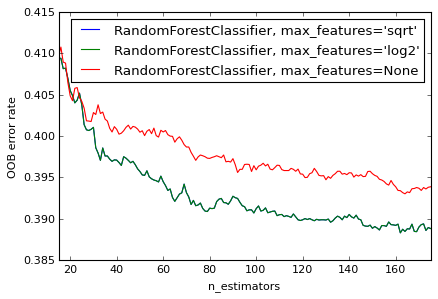

In [143]:
RANDOM_STATE = 123
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
%matplotlib inline
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()


In [46]:
from xgboost import XGBClassifier

In [49]:
X_train, X_test, y_train, y_test = train_test_split(ssX, y,
                                                    test_size=0.33)

model = XGBClassifier()
model.fit(X_train, y_train)

feat_labels = ['pos', 'neg', 'neutral', 'valence', 'numbertokens', 'numberhashtags',
               'numberlinks', 'verbs', 'persprp', 'adjectives']

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
model_train = accuracy_score(y_train, y_train_pred)
model_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (model_train, model_test))
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print('AUC: %f' % roc_auc)

  1) numbertokens                   0.273570
  2) valence                        0.142195
  3) numberlinks                    0.115920
  4) numberhashtags                 0.105100
  5) neutral                        0.098918
  6) neg                            0.064915
  7) persprp                        0.058733
  8) adjectives                     0.051005
  9) pos                            0.051005
 10) verbs                          0.038640
Train/test accuracies: 0.637/0.629
AUC: 0.629704


## different attempt

trying from http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

In [271]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=80000)

array([0, 1])

(39232, 10)

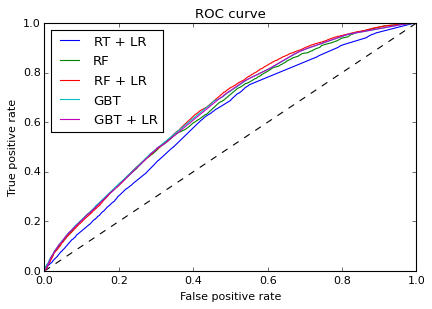

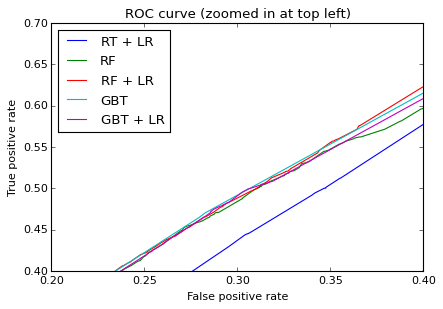

In [292]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

n_estimator = 10
#X, y = make_classification(n_samples=80000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
    random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)


# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)


# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.2, 0.4)
plt.ylim(0.4, 0.7)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [205]:
pipeline.predict_proba(X_test)[:, 1]

array([ 0.38494773,  0.97950902,  0.61297862, ...,  0.61355728,
        0.00225023,  0.38739329])

In [206]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

400000